# DataBaseCleaning

## Part 1: Load DataFrames and Import Libraries

In [2]:
%load_ext autoreload
%autoreload 2

import importlib
import SAP_cleaning_functions as f
importlib.reload(f)
import os
import pandas as pd

In [3]:
# Define the folder where the files are located
folder_name = "DF_cleaned"

# List of base names for the DataFrames
df_names = [
    "df_equipment", "df_orders", "df_equipment_decomission_request", "df_storage",

]

# Dynamically load the DataFrames and assign them as individual variables
for name in df_names:
    file_path = os.path.join("../",folder_name, f"{name}.csv")
    globals()[name] = pd.read_csv(file_path)

print("File loading completed.")




File loading completed.


## Part 2: Equipment Without Hospital


As we observed during the data cleaning process, several pieces of equipment had their **hospital data removed**.  
These are clearly devices that are **scheduled for decommissioning.**  

We mark these pieces of equipment as candidates for removal.  


In [4]:
df_equipment_missing_hospital = df_equipment[df_equipment['Hospital'].isnull()]

In [5]:
df_equipment_missing_hospital.head(2)

,Equipment_ID,Type,Subtype,Serial_number,ABC,Purchase_value,Device_status,Responsible,Hospital,Department,Manufacturer,Model,Purchase_year,Last_order_year,Decommission_request
81,T87-FTUWT,T87,St4,FTUWT,C,79207.92,Normal,NaN,NaN,NaN,F167,M369,2012,2000,0.0
206,T22-UUCC,T22,St560,UUCC,A,0.00,Normal,NaN,NaN,NaN,F374,M1316,2012,2000,0.0


In [6]:
df_equipment_missing_hospital.shape

(182, 15)

Let's check the year of the last order, which represents the most recent recorded maintenance or service request for these pieces of equipment.  


We observe that **many of these pieces of equipment have recent orders**.  
- **Mark for removal** equipment with **orders from 2020 or earlier**.  
- **Mark the rest for further analysis** to assess their current status and necessity.  


We are only interested in the **Equipment_ID** field, as the rest of the information can be retrieved from the df_equipment DataFrame.  

In [7]:
# Equipment to be removed: those whose last order was before 2020 or whose purchase year was before 2013
df_remove_missing_hospital = df_equipment_missing_hospital[
    (df_equipment_missing_hospital["Last_order_year"] < 2020.0) | (df_equipment_missing_hospital["Purchase_year"] < 2013)
]

# Equipment to analyze: those that are in df_equipment_missing_hospital and are not marked for removal
df_analyze_missing_hospital = df_equipment_missing_hospital[
    ~df_equipment_missing_hospital["Equipment_ID"].isin(df_remove_missing_hospital["Equipment_ID"])
]


In [8]:
df_remove_missing_hospital.groupby("Purchase_year").size().sort_index(ascending=False)

Purchase_year
2024     7
2023     4
2020     1
2017     1
2016     4
2015     2
2014     8
2013    12
2012    53
2011     9
2010     2
2009     5
2008    20
2005    31
dtype: int64

In [9]:
df_remove_missing_hospital.groupby("Last_order_year").size().sort_index(ascending=False)

Last_order_year
2025    12
2024     1
2023     1
2019     4
2018     9
2017    12
2016    11
2015     7
2014     6
2013     9
2012    10
2011     1
2009     1
2000    75
dtype: int64

In [10]:
print(f"Equipment to delete without Hospital : {df_remove_missing_hospital.shape[0]}")
print(f"Equipment to analyze without Hospital: {df_analyze_missing_hospital.shape[0]}")

Equipment to delete without Hospital : 159
Equipment to analyze without Hospital: 23


## Part 3: Unusual Locations  

Reviewing the information in the Storagees dataset, we found that some hospitals **do not have an assigned responsible center**, and several of them have **very few pieces of equipment.**  


In [11]:
df_storage.tail(5)

,Responsible,Storage,Hospital
47,NAN,NaN,H38
48,NAN,NaN,NaN
49,NAN,NaN,H36
50,NAN,NaN,H48
51,NAN,NaN,BAJ


In [12]:
# Group equipment by hospital and sort in ascending order based on the number of equipment
df_hospitales_filtrados = df_equipment.groupby("Hospital").size().sort_values().reset_index()
df_hospitales_filtrados.columns = ["Hospital", "Quantity"]

# Merge with warehouse information to obtain the responsible person
df_merged = df_hospitales_filtrados.merge(df_storage, on="Hospital", how="left")

# Filter hospitals without a properly assigned responsible person
df_sin_Responsible = df_merged[df_merged["Responsible"] == "NAN"]

# Display result
df_sin_Responsible


,Hospital,Quantity,Responsible,Storage
0,H50,1,NAN,NaN
1,H49,1,NAN,NaN
2,H48,1,NAN,NaN
3,H41,2,NAN,NaN
5,H45,2,NAN,NaN
6,H43,3,NAN,NaN
7,H46,4,NAN,NaN
8,H44,4,NAN,NaN
12,H38,10,NAN,NaN
14,H36,14,NAN,NaN


Based on this, we observe that:  

- There are three locations with only **one piece of equipment**.  
- There is **one location** for **decommissioned equipment** and another for **equipment stored in the warehouse**.  


In [13]:
df_small_hospitals = df_sin_Responsible[df_sin_Responsible["Quantity"] < 5]
df_small_hospitals

,Hospital,Quantity,Responsible,Storage
0,H50,1,NAN,NaN
1,H49,1,NAN,NaN
2,H48,1,NAN,NaN
3,H41,2,NAN,NaN
5,H45,2,NAN,NaN
6,H43,3,NAN,NaN
7,H46,4,NAN,NaN
8,H44,4,NAN,NaN


We will **mark for removal** the equipment located in the **decommissioned (BAJA) location**.  
For the remaining locations, further analysis is needed to determine their relevance and **assign a responsible person** if necessary.  


In [14]:
df_baja_hospital = df_equipment[df_equipment["Hospital"] == "BAJ"]
df_baja_hospital.groupby("Last_order_year").size().sort_index(ascending=False)


Last_order_year
2025    1
2024    2
2023    1
2022    1
2020    1
2018    1
2017    2
2016    1
2013    1
2000    3
dtype: int64

As before, we notice that **some of these pieces of equipment have very recent orders**.  
We will classify them into three categories:  

- **Equipment in a decommissioned hospital (BAJA) whose last order was before 2020 or purchased before 2013 → Mark for removal**.  
- **Equipment in a decommissioned hospital (BAJA) that is not marked for removal → Mark for further analysis**.  
- **Equipment without an assigned storage location → Mark for further analysis**.  
- **Equipment with hospital with less than 4 equipments -> Mark for further analysis**.


In [15]:
# Identify equipment in a decommissioned hospital (BAJA) whose last order was before 2020 or purchased before 2013 → Mark for removal
df_remove_baja_hospital = df_baja_hospital[
    (df_baja_hospital["Last_order_year"] < 2020.0) | (df_baja_hospital["Purchase_year"] < 2013)
]["Equipment_ID"]

# Identify equipment in a decommissioned hospital (BAJA) that is not marked for removal → Mark for further analysis
df_analyze_baja_hospital = df_baja_hospital[
    ~df_baja_hospital["Equipment_ID"].isin(df_remove_baja_hospital)
]["Equipment_ID"]

# Identify equipment in hospitals without an assigned responsible → Mark for further analysis
df_analyze_no_storage = df_equipment.loc[
    df_equipment["Hospital"].isin(df_sin_Responsible["Hospital"]), ["Equipment_ID"]
]

df_analyze_small_hospitals = df_equipment.loc[
    df_equipment["Hospital"].isin(df_small_hospitals["Hospital"]), ["Equipment_ID"]
]


In [16]:
print(f"Equipment to delete with BAJ Hospital : {df_remove_baja_hospital.shape[0]}")
print(f"Equipment to analyze with BAJ Hospital: {df_analyze_baja_hospital.shape[0]}")
print(f"Equipment to analyze without responsible: {df_analyze_no_storage.shape[0]}")
print(f"Equipment to analyze in small hospitals: {df_analyze_small_hospitals.shape[0]}")

Equipment to delete with BAJ Hospital : 11
Equipment to analyze with BAJ Hospital: 3
Equipment to analyze without responsible: 294
Equipment to analyze in small hospitals: 18


## Part 4: Equipment Status  

Let's analyze the **equipment status** to identify any relevant patterns or inconsistencies.  

In [17]:
df_equipment.groupby("Device_status").size().sort_values(ascending=False)


Device_status
Normal    11706
NOEN        500
dtype: int64

We observe that equipment can belong to three categories, which include:  

- Normal  
- NOEN (Not found)  


### Part 4-a: Categories NOEN

The category NOEN are for those equipment that have not been found for a while

All of these pieces of equipment are **unusual and require further analysis**.  
However, we will **mark for removal** those that meet the following criteria:  

- **No hospital assigned**.  
- **Have a decommissioning request**.  
- **Purchased before 2013** and either:  
  - **Last recorded order was before 2013**, or  
  - **No recorded orders at all**.  


In [18]:
df_NOEN = df_equipment[df_equipment["Device_status"] == "NOEN"]
print(f"Equipment with NOEN category: {df_NOEN.shape[0]}")

Equipment with NOEN category: 500


In [19]:
## Filter NOEN equipment that meets the removal criteria

# Equipment categorized as NOEN without a hospital assignment
df_NOEN_Sin_Hospital = df_NOEN[df_NOEN["Hospital"].isna()]

# Equipment categorized as NOEN with a decommissioning request
df_NOEN_Decommission_request = df_NOEN[df_NOEN["Decommission_request"] == 1]

# Equipment purchased before 2013 with either no recorded orders or last order before 2013
df_NOEN_anteriores_2013 = df_NOEN[
    (df_NOEN["Purchase_year"] < 2013) &
    ((df_NOEN["Last_order_year"] < 2013))
]

## Print summary of identified equipment for removal
print("NOEN without hospital:", df_NOEN_Sin_Hospital.shape[0])
print("NOEN with decommissioning request:", df_NOEN_Decommission_request.shape[0])
print("NOEN purchased before 2013 with last order before 2013 or no orders:", df_NOEN_anteriores_2013.shape[0])

## Merge the filtered DataFrames into a single list of equipment to be removed
df_remove_NOEN = pd.concat([df_NOEN_Sin_Hospital, df_NOEN_Decommission_request, df_NOEN_anteriores_2013]).drop_duplicates()["Equipment_ID"]

## Print final count of NOEN equipment marked for removal
print("Total NOEN equipment marked for removal:", df_remove_NOEN.shape[0])

df_analyze_NOEN = df_NOEN[~df_NOEN["Equipment_ID"].isin(df_remove_NOEN)]
print("Total NOEN equipment to analyze:", df_analyze_NOEN.shape[0])
df_analyze_NOEN["Purchase_year"].value_counts().sort_index()


NOEN without hospital: 35
NOEN with decommissioning request: 3
NOEN purchased before 2013 with last order before 2013 or no orders: 147
Total NOEN equipment marked for removal: 182
Total NOEN equipment to analyze: 318


Purchase_year
2005    11
2007     3
2008    63
2009     7
2010    12
2011    23
2012    51
2013    31
2014    29
2015    16
2016     8
2017    41
2018     4
2019     1
2020     4
2021     1
2022     4
2023     9
Name: count, dtype: int64

There are many pieces of equipment with a purchase date before 2008 (over 17 years old), which is noteworthy. Let's check the year of the last order.

In [20]:
# Filter NOEN equipment with a purchase date on or before 2008
equipos_NOEN_ant_2008 = df_analyze_NOEN[df_analyze_NOEN["Purchase_year"] <= 2008]

# Merge with the orders DataFrame to obtain the last order information
equipos_NOEN_ant_2008["Last_order_year"].value_counts().sort_index()


Last_order_year
2013     2
2014     1
2015     4
2017     8
2018     5
2019     9
2020     3
2021    10
2022     5
2023     5
2024    15
2025    10
Name: count, dtype: int64

Let's mark these pieces of equipment for analysis.

In [21]:
df_analyze_NOEN_pre2008 = equipos_NOEN_ant_2008
print(" Total NOEN with purchase before 2008 equipment to analyze:", df_analyze_NOEN_pre2008.shape[0])

 Total NOEN with purchase before 2008 equipment to analyze: 77


We can also see that many pieces of equipment were bought recently but are marked as NOEN.

We need to analize these further

In [22]:
df_analyze_NOEN_post2020 = df_analyze_NOEN[df_analyze_NOEN["Purchase_year"] >= 2020]
print("NOEN equipment to analyze purchased after 2020:", df_analyze_NOEN_post2020.shape[0])

NOEN equipment to analyze purchased after 2020: 18


## Part 5: Equipment purchased before 2013.



Equipment purchased before 2013 is now over **11 years old** and is more prone to failure. To ensure data accuracy and proper equipment tracking, we will remove those that meet the following criteria:  

- **Last order before 2013 or missing data.**  
- **Marked for decommissioning.**  
- **No assigned hospital data.**  

However, we will **mark for further analysis** any equipment that is more than **11 years old** but does not fall into any of these categories. These cases require a closer review to determine their status and whether they should remain in the database.  


In [23]:
df_old = df_equipment[df_equipment["Purchase_year"] < 2013]

In [24]:
## Filter NOEN equipment that meets the removal criteria

# Equipment categorized as NOEN without a hospital assignment
df_Old_Sin_Hospital = df_old[df_old["Hospital"].isna()]

# Equipment categorized as NOEN with a decommissioning request
df_old_Decommission_request = df_old[df_old["Decommission_request"] == 1]

# Equipment purchased before 2013 with either no recorded orders or last order before 2013
df_old_anteriores_2013 = df_NOEN[
    ((df_NOEN["Last_order_year"] < 2013))
]

## Print summary of identified equipment for removal
print("Old without hospital:", df_Old_Sin_Hospital.shape[0])
print("Old with decommissioning request:", df_old_Decommission_request.shape[0])
print("Old with last order before 2013 or no orders:", df_old_anteriores_2013.shape[0])

## Merge the filtered DataFrames into a single list of equipment to be removed
df_remove_old_devices = pd.concat([df_Old_Sin_Hospital, df_old_Decommission_request, df_old_anteriores_2013]).drop_duplicates()["Equipment_ID"]

## Print final count of NOEN equipment marked for removal
print("Total old equipment marked for removal:", df_remove_old_devices.shape[0])

df_analyze_old_devices = df_old[~df_old["Equipment_ID"].isin(df_remove_old_devices)].drop_duplicates()
df_analyze_old_devices = df_analyze_old_devices[(df_analyze_old_devices["Last_order_year"] <= 2013)]

print("Total old equipment to analyze:", df_analyze_old_devices.shape[0])


Old without hospital: 120
Old with decommissioning request: 82
Old with last order before 2013 or no orders: 175
Total old equipment marked for removal: 371
Total old equipment to analyze: 1074


All of this equipment should catch our attention as it is over 13 years old, making it likely to start failing more frequently.

## Part 6: Equipment with las order before 2013 or without it

These pieces of equipment have **over 10 years** without a formal record, raising concerns about their status and reliability. To ensure accurate tracking, we will remove those that meet any of the following criteria:  

- **Purchased before 2013.**  
- **Marked for decommissioning.**  
- **No assigned hospital data.**  

However, if the equipment does not meet the removal criteria but was **purchased before 2013**, we will **mark it for further analysis** to assess its current status and necessity in the database.  


In [25]:
len((df_equipment[df_equipment["Last_order_year"] < 2014]))

3286

In [26]:
equipos_sin_orden_o_ant_2013 = df_equipment[(df_equipment["Last_order_year"] < 2014)]


Let's mark for removal the equipment that has a decommission request, is not assigned to a hospital, or was purchased before 2013.

In [27]:
## **Filter NOEN equipment that meets the removal criteria**

# Equipment without a hospital assignment
df_order_Sin_Hospital = equipos_sin_orden_o_ant_2013[
    equipos_sin_orden_o_ant_2013["Hospital"].isna()
]["Equipment_ID"]

# Equipment with a decommissioning request
df_order_Decommission_request = equipos_sin_orden_o_ant_2013[
    equipos_sin_orden_o_ant_2013["Decommission_request"] == 1
]["Equipment_ID"]

# Equipment last ordered before 2013 or with no recorded orders and purchased before 2013 → Mark for removal
df_order_anteriores_2013 = equipos_sin_orden_o_ant_2013[
    (equipos_sin_orden_o_ant_2013["Purchase_year"] < 2013)
    & ((equipos_sin_orden_o_ant_2013["Last_order_year"] < 2013))
]["Equipment_ID"].drop_duplicates()

## Print summary of identified equipment for removal
print("Old equipment without hospital:", df_order_Sin_Hospital.shape[0])
print("Old equipment with decommissioning request:", df_order_Decommission_request.shape[0])
print("Old equipment with last order before 2013 or no orders:", df_order_anteriores_2013.shape[0])

## Merge the filtered DataFrames into a single list of equipment to be removed
df_remove_no_orders = pd.concat([df_order_Sin_Hospital, df_order_Decommission_request, df_order_anteriores_2013]).drop_duplicates()

## Print final count of NOEN equipment marked for removal
print("Total equipment marked for removal:", df_remove_no_orders.shape[0])

# **Mark for analysis**: Equipment that is **not** in the removal list but was purchased before 2013
df_analyze_no_orders = equipos_sin_orden_o_ant_2013[
    (~equipos_sin_orden_o_ant_2013["Equipment_ID"].isin(df_remove_no_orders))
    & (equipos_sin_orden_o_ant_2013["Purchase_year"] < 2013)
]

print("Total equipment to analyze:", df_analyze_no_orders.shape[0])


Old equipment without hospital: 96
Old equipment with decommissioning request: 14
Old equipment with last order before 2013 or no orders: 1225
Total equipment marked for removal: 1267
Total equipment to analyze: 61


## Part 7: Decommission request.

In [28]:
df_equipment_SAP_Con_Sol_Baja = df_equipment[df_equipment["Decommission_request"] == 1]
df_equipment_SAP_Con_Sol_Baja["Purchase_year"].value_counts().sort_index()

Purchase_year
2005     5
2007     1
2008    32
2009     3
2010     1
2011     5
2012    35
2013    11
2014     4
2015    11
2016     6
2017     3
2018     5
2019     1
2023     1
2024     2
Name: count, dtype: int64

Most of these pieces of equipment are old, and it's surprising that they haven't been decommissioned yet. The next step in the analysis is to check if any of them have more than one decommission request.

In [29]:
# Count the number of times each piece of equipment appears in df_equipment_decomission_request
equipment_count = df_equipment_decomission_request["Equipment_ID"].value_counts()

# Add the count to df_equipment_SAP_Con_Sol_Baja
df_equipment_SAP_Con_Sol_Baja["Number_of_Appearances"] = df_equipment_SAP_Con_Sol_Baja["Equipment_ID"].map(equipment_count).fillna(0).astype(int)

# Display the result
# Filter equipment that appears more than once
df_equipment_more_than_once = df_equipment_SAP_Con_Sol_Baja[df_equipment_SAP_Con_Sol_Baja["Number_of_Appearances"] > 1]

# Show the result
print("Equipment appearing more than once:", df_equipment_more_than_once.shape[0])
df_equipment_decomission_request[df_equipment_decomission_request["Equipment_ID"].isin(df_equipment_more_than_once["Equipment_ID"])]


Equipment appearing more than once: 4


C:\Users\frano\AppData\Local\Temp\ipykernel_29504\1602093726.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_equipment_SAP_Con_Sol_Baja["Number_of_Appearances"] = df_equipment_SAP_Con_Sol_Baja["Equipment_ID"].map(equipment_count).fillna(0).astype(int)


,Equipment_ID,Created,Modified,Status
791,T4-UKTF,2025-02-07 15:43:23,2025-02-07 15:43:25,NaN
799,T4-LTSKHECCTT,2025-02-14 09:30:30,2025-02-14 09:30:31,NaN
801,T4-UKTF,2025-02-14 09:33:25,2025-02-14 09:33:26,NaN
822,T4-LTSKHECCTT,2025-02-14 13:06:16,2025-02-14 13:06:17,NaN


We see that there are 4 cases with more than one decommission request that have not yet been decommissioned. Let's take a closer look at these pieces of equipment.

Let's mark for removal the equipment that has a decommission request and was purchased before 2018. The rest of the equipment is noteworthy, as they were purchased recently and already have a decommission request.

In [30]:
df_remove_with_request = df_equipment_SAP_Con_Sol_Baja[df_equipment_SAP_Con_Sol_Baja["Purchase_year"] < 2018]["Equipment_ID"]
df_analyze_with_request = df_equipment_SAP_Con_Sol_Baja[df_equipment_SAP_Con_Sol_Baja["Purchase_year"] >= 2018]["Equipment_ID"]

print("Equipment to delete with decommissioning request:", df_remove_with_request.shape[0])
print("Equipment to analyze with decommissioning request:", df_analyze_with_request.shape[0])

Equipment to delete with decommissioning request: 117
Equipment to analyze with decommissioning request: 9


## Part 8: Duplicate equipment

Let's check if there are duplicate pieces of equipment with the same serial number. To do this, we will look for equipment that has the same last four digits of the serial number and the same model or brand.

In [31]:
df_equipment["Serial_number_Last_4_Digits"] = df_equipment["Serial_number"].str[-4:]

In [32]:
# Filter equipment with a valid serial number (non-empty and non-null)
df_with_serial = df_equipment[df_equipment['Serial_number'].notna() & (df_equipment['Serial_number'].str.strip() != '')]

# Identify potential duplicates based on the serial number
serial_duplicates = df_with_serial[df_with_serial.duplicated(subset=['Serial_number'], keep=False)]

# Sort by Serial Number for better visualization
serial_duplicates = serial_duplicates.sort_values('Serial_number')

# Filter only those with the same manufacturer or model
duplicates_same_manufacturer_model = serial_duplicates[
    serial_duplicates.duplicated(subset=['Serial_number', 'Manufacturer'], keep=False) | 
    serial_duplicates.duplicated(subset=['Serial_number', 'Model'], keep=False)
]

# Display the number of possible duplicates
print(f"\nNumber of equipment with possible serial number duplicates: {duplicates_same_manufacturer_model.shape[0]}")

# Show a sample of possible duplicates
print("Sample of possible serial number duplicates:")
duplicates_same_manufacturer_model[['Equipment_ID', 'Serial_number', 'Serial_number_Last_4_Digits', 'Manufacturer', 'Model']].head(10)



Number of equipment with possible serial number duplicates: 26
Sample of possible serial number duplicates:


,Equipment_ID,Serial_number,Serial_number_Last_4_Digits,Manufacturer,Model
6577,T35-ARXDSSIS,ARXDSSIS,SSIS,F15,M159
7095,T3-ARXDSSIS,ARXDSSIS,SSIS,F15,M331
11980,T15-ESISTV,ESISTV,ISTV,F12,M37
11878,T19-ESISTV,ESISTV,ISTV,F12,M37
5582,T94-ISIISYUKSU,ISIISYUKSU,UKSU,F73,M524
8528,T67-ISIISYUKSU,ISIISYUKSU,UKSU,F2,M873
9111,T14-ISIISYUKSU,ISIISYUKSU,UKSU,F2,M24
6314,T21-ISIISYUKSU,ISIISYUKSU,UKSU,F73,M196
3965,T177-ISSVGAAT,ISSVGAAT,GAAT,F367,M1752
6742,T104-ISSVGAAT,ISSVGAAT,GAAT,F367,M1672


These cases need to be analyzed in more detail, but we can already see some suspected duplicates, such as **T94-ISIISYUKSU** and **T67-ISIISYUKSU**. 

In [33]:
df_analyze_duplicates = duplicates_same_manufacturer_model.copy()

## Final List of Equipment to Remove


### Summary

#### 1. Equipment Without Hospital  
- Last order before 2020 or purchased before 2013.  
- Source file: `df_remove_missing_hospital`  

#### 2. Equipment in Decommissioned Hospitals (BAJA)  
- Last order before 2020 or purchased before 2013.  
- Source file: `df_remove_baja_hospital`  

#### 3. NOEN Equipment (Non-Operational Equipment)  
- No assigned hospital.  
- Marked for decommissioning.  
- Purchased before 2013 with last order before 2013 or missing.  
- Source file: `df_remove_NOEN`  

#### 4. Equipment Purchased Before 2013  
- Last order before 2013 or missing. 
- Marked for decommissioning.  
- No assigned hospital.
- Source file: `df_remove_old_devices`  

#### 5. Equipment with Last Order Before 2013 or Missing  
- Purchased before 2013. 
- Marked for decommissioning or no assigned hospital.  
- Source file: `df_remove_no_orders`  

#### 6. Equipment with a Decommission Request  
- Purchased before 2018.  
- Source file: `df_remove_with_request`  


### Code

In [34]:
df_remove_baja_hospital.shape

(11,)

In [35]:
# Create a dictionary with all DataFrames to be removed
df_dict = {
    "df_remove_baja_hospital": df_remove_baja_hospital,  # Decommissioned hospitals (BAJA)
    "df_remove_NOEN": df_remove_NOEN,  # NOEN equipment meeting removal criteria
    "df_remove_old_devices": df_remove_old_devices,  # Equipment purchased before 2013
    "df_remove_no_orders": df_remove_no_orders,  # Equipment with last order before 2013 or missing
    "df_remove_missing_hospital": df_remove_missing_hospital,  # Equipment without hospital assigned
    "df_remove_with_request": df_remove_with_request,  # Equipment with a decommission request before 2018
}

# Combine all removal lists into a single DataFrame
df_all = pd.concat(df_dict.values(), keys=df_dict.keys()).reset_index(level=0) \
    .rename(columns={"level_0": "Source"}).drop_duplicates()

# Create a pivot table to indicate in which lists each equipment appears
df_pivot = df_all.pivot_table(index="Equipment_ID", columns="Source", aggfunc="size", fill_value=0)

# Generate a final list of unique equipment to be removed
df_recommendation_remove = pd.DataFrame(df_all["Equipment_ID"].unique(), columns=["Equipment_ID"])

# Add the final removal recommendation DataFrame to the dictionary
df_dict["df_recommendation_remove"] = df_recommendation_remove

# Count the total number of unique equipment to be removed
total_equipment_remove = df_recommendation_remove.shape[0]

print(f"Total equipment marked for removal: {total_equipment_remove}")


Total equipment marked for removal: 1477


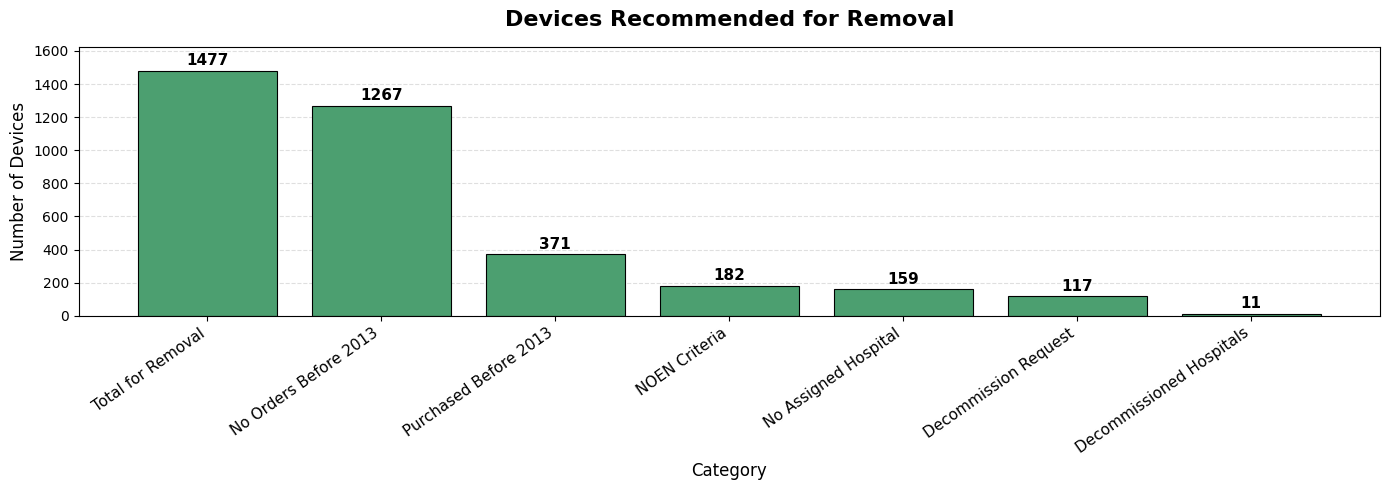

In [36]:
import matplotlib.pyplot as plt
import os

# Count and sort values
counts_dict = {key: len(value) for key, value in df_dict.items()}
sorted_counts = dict(sorted(counts_dict.items(), key=lambda item: item[1], reverse=True))

# Rename keys for display
rename_dict = {
    "df_recommendation_remove": "Total for Removal",
    "df_remove_no_orders": "No Orders Before 2013",
    "df_remove_old_devices": "Purchased Before 2013",
    "df_remove_NOEN": "NOEN Criteria",
    "df_remove_missing_hospital": "No Assigned Hospital",
    "df_remove_with_request": "Decommission Request",
    "df_remove_baja_hospital": "Decommissioned Hospitals",
}

keys = list(sorted_counts.keys())
values = list(sorted_counts.values())
labels = [rename_dict[k] for k in keys]

# Create figure
fig, ax = plt.subplots(figsize=(14, 5))
bars = ax.bar(range(len(keys)), values, color="#4C9F70", edgecolor="black", linewidth=0.8)

# Axis labels and title
ax.set_title("Devices Recommended for Removal", fontsize=16, weight='bold', pad=15)
ax.set_xlabel("Category", fontsize=12)
ax.set_ylabel("Number of Devices", fontsize=12)
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(labels, rotation=35, ha="right", fontsize=11)

# Add count labels above bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{int(height)}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 2),  # Offset above the bar
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=11, color="black", weight="bold")

# Styling
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.set_axisbelow(True)
ax.set_ylim(0, max(values) * 1.1)  # Ensure enough space above tallest bar

plt.tight_layout()

# Save the plot
output_folder = os.path.join("..", "images")
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, "removal_devices_barplot_cleaned.png")
plt.savefig(output_path, dpi=300)

plt.show()


In [37]:
# Count the total number of equipment marked for removal
print(f"Total equipment marked for removal: {df_recommendation_remove.shape[0]}")

# Calculate the total purchase value of the equipment in df_recommendation_remove
total_cost_deco = df_equipment.loc[df_equipment["Equipment_ID"].isin(df_recommendation_remove["Equipment_ID"]), "Purchase_value"].sum()

total_cost = df_equipment["Purchase_value"].sum()

Percentage = (total_cost_deco / total_cost) * 100


# Print the formatted percentage
print(f"Percentage of the total purchase cost of the equipment in df_recommendation_remove: {Percentage.round(1)}")

# Add df_recommendation_remove to the dictionary
df_dict["df_recommendation_remove"] = df_recommendation_remove


Total equipment marked for removal: 1477
Percentage of the total purchase cost of the equipment in df_recommendation_remove: 4.7


Total equipment marked for removal: 1477
Information about the equipment marked for removal:


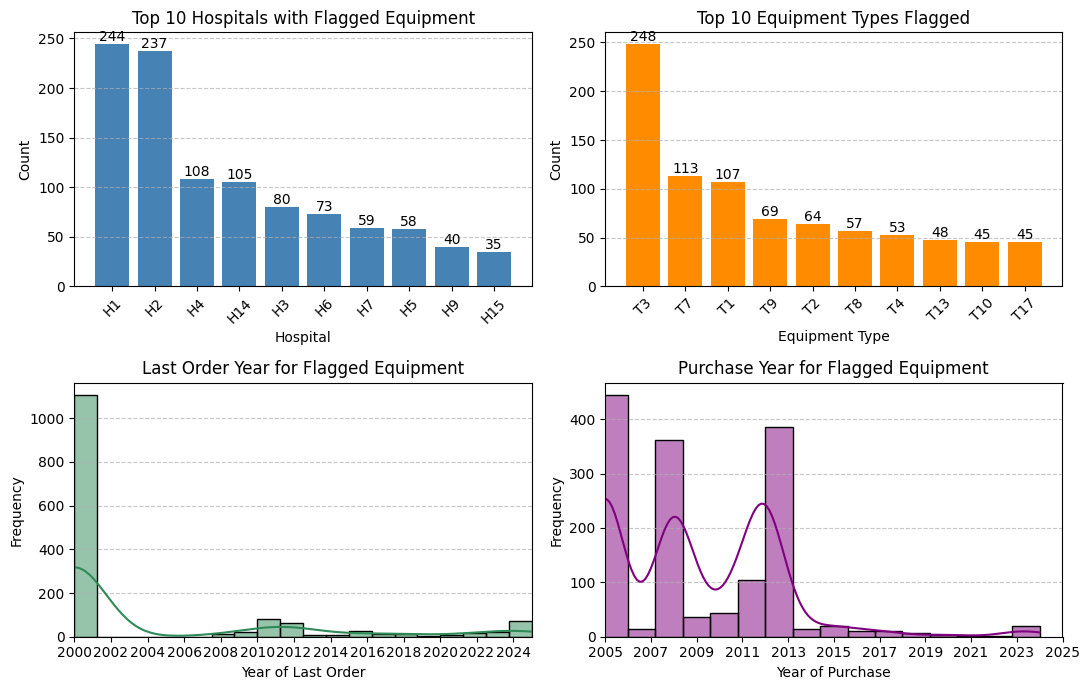

In [40]:
print(f"Total equipment marked for removal: {total_equipment_remove}")
print("Information about the equipment marked for removal:")

f.visualize_flagged_equipment(df_equipment[df_equipment["Equipment_ID"].isin(df_recommendation_remove["Equipment_ID"])].copy(),output_name="flagged_removal_equipment")


**Hospitals with the Most Flagged Equipment:** H2 and H1 have the highest number of flagged devices, significantly surpassing other hospitals. This could indicate maintenance inefficiencies or a need for better asset management.

**Most Flagged Equipment Types:** T3 equipments have the highest number of flagged devices.

**Last Order Year Distribution:** Many flagged devices had their last recorded order in recent years (2023-2024), but there are also a significant number from before 2013, indicating obsolete equipment that might require urgent replacement.

**Purchase Year Distribution:** There are peaks in flagged equipment purchases around 2005, 2008, and 2012, suggesting that equipment from these years is more prone to being flagged, possibly due to aging or lack of maintenance.

In [38]:
f.save_clean_dataframes("DF_Remove1", df_dict)


⚠️ df_remove_baja_hospital was not a DataFrame, converting to empty DataFrame with 'Equipment_ID'.
✅ Saved: DF_Remove1\df_remove_baja_hospital.csv
⚠️ df_remove_NOEN was not a DataFrame, converting to empty DataFrame with 'Equipment_ID'.
✅ Saved: DF_Remove1\df_remove_NOEN.csv
⚠️ df_remove_old_devices was not a DataFrame, converting to empty DataFrame with 'Equipment_ID'.
✅ Saved: DF_Remove1\df_remove_old_devices.csv
⚠️ df_remove_no_orders was not a DataFrame, converting to empty DataFrame with 'Equipment_ID'.
✅ Saved: DF_Remove1\df_remove_no_orders.csv
✅ Saved: DF_Remove1\df_remove_missing_hospital.csv
⚠️ df_remove_with_request was not a DataFrame, converting to empty DataFrame with 'Equipment_ID'.
✅ Saved: DF_Remove1\df_remove_with_request.csv
✅ Saved: DF_Remove1\df_recommendation_remove.csv


## Final List of Equipment to Analyze  

### Summary


#### 1. Equipment Without Hospital  
- Not marked for removal.  
- Source file: `df_analyze_missing_hospital`  

#### 2. Equipment in Decommissioned Hospitals (BAJA)  
- Not marked for removal.  
- Source file: `df_analyze_baja_hospital`  

#### 3. Equipment Without an Assigned Storage Location  
- Source file: `df_analyze_no_storage`  

#### 4. Equipment in Hospitals with Less than 4 Devices  
- Source file: `df_analyze_small_hospitals`  

#### 6. NOEN Equipment for Further Analysis  
- Not marked for removal but purchased before 2013.  
- Source file: `df_analyze_NOEN`  

#### 7. NOEN Equipment Purchased Before 2008  
- Older NOEN equipment requiring review.  
- Source file: `df_analyze_NOEN_pre2008`  

#### 8. NOEN Equipment Purchased After 2020  
- Recently acquired NOEN equipment requiring review.  
- Source file: `df_analyze_NOEN_post2020`  

#### 9. Equipment Purchased Before 2013 but Not Meeting Removal Criteria  
- Over 11 years old but still active. 
- Last order before 2013 or missing.   
- Source file: `df_analyze_old_devices`  

#### 10. Equipment with Last Order Before 2013 or Missing but Not for Removal  
- Purchased before 2013.  
- Source file: `df_analyze_no_orders`  

#### 11. Equipment with a Decommission Request but Purchased After 2018  
- Recently purchased but already flagged for decommissioning.  
- Source file: `df_analyze_with_request`  

#### 12. Duplicate Equipment for Analysis  
- Equipment with potential serial number duplicates.  
- Source file: `df_analyze_duplicates`  

### Code

In [42]:
# Create a dictionary with all DataFrames to be analyzed
df_analyze_dict = {
    "df_analyze_missing_hospital": df_analyze_missing_hospital,  # Equipment without a hospital but not marked for removal  
    "df_analyze_baja_hospital": df_analyze_baja_hospital,  # Equipment in decommissioned hospitals (BAJA) but not marked for removal
    "df_analyze_no_storage": df_analyze_no_storage,  # Equipment without an assigned storage location
    "df_analyze_small_hospitals": df_analyze_small_hospitals,  # Equipment in hospitals with less than 4 devices
    "df_analyze_NOEN": df_analyze_NOEN,  # NOEN equipment for further analysis
    "df_analyze_NOEN_pre2008": df_analyze_NOEN_pre2008,  # NOEN equipment purchased before 2008
    "df_analyze_NOEN_post2020": df_analyze_NOEN_post2020,  # NOEN equipment purchased after 2020
    "df_analyze_old_devices": df_analyze_old_devices,  # Equipment purchased before 2013 but not meeting removal criteria
    "df_analyze_no_orders": df_analyze_no_orders,  # Equipment with last order before 2013 or missing but not for removal
    "df_analyze_with_request": df_analyze_with_request,  # Equipment with a decommission request but purchased after 2018
    "df_analyze_duplicates": df_analyze_duplicates  # Duplicate equipment for analysis

}


# Combine all analysis lists into a single DataFrame
df_analyze_all = pd.concat(df_analyze_dict.values(), keys=df_analyze_dict.keys()).reset_index(level=0) \
    .rename(columns={"level_0": "Source"}).drop_duplicates()

# Create a pivot table to indicate in which lists each equipment appears
df_analyze_pivot = df_analyze_all.pivot_table(index="Equipment_ID", columns="Source", aggfunc="size", fill_value=0)

# Generate a final list of unique equipment to be analyzed
df_recommendation_analyze = pd.DataFrame(df_analyze_all["Equipment_ID"].unique(), columns=["Equipment_ID"])

# Add the final analysis recommendation DataFrame to the dictionary
df_analyze_dict["df_recommendation_analyze"] = df_recommendation_analyze

# Count the total number of unique equipment to be analyzed
total_equipment_analyze = df_recommendation_analyze.shape[0]

print(f"Total equipment marked for analysis: {total_equipment_analyze}")

# Contar el total de equipos únicos a remove
total_equipos_analyze = df_analyze_duplicates.shape[0]

print(f"Total equipment marked for duplicate: {df_analyze_duplicates.shape[0]}")


Total equipment marked for analysis: 1619
Total equipment marked for duplicate: 26


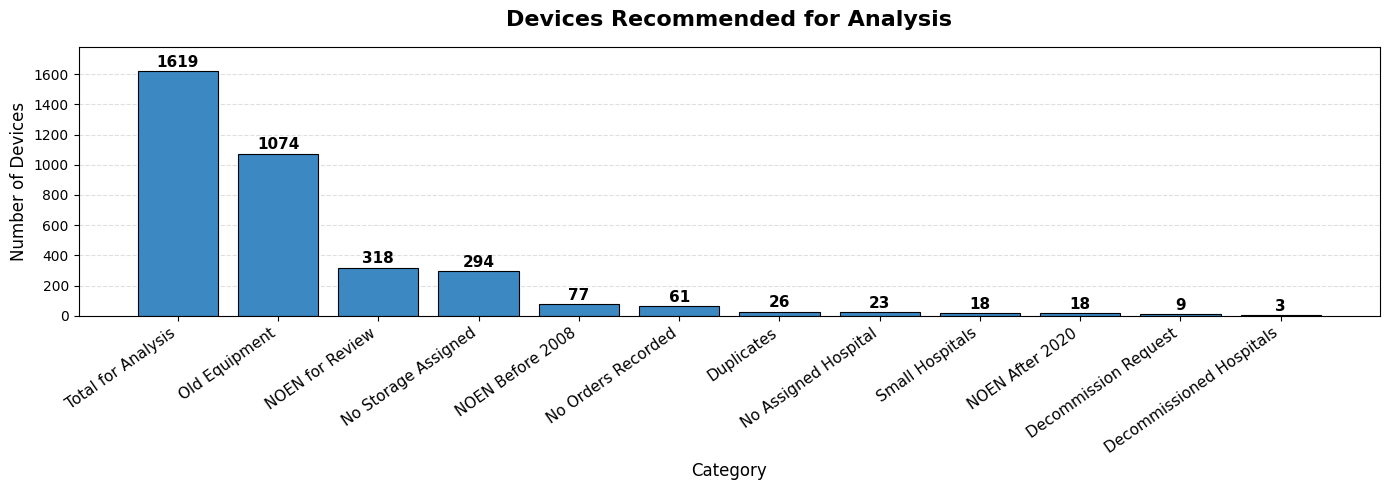

In [43]:
import os
import matplotlib.pyplot as plt

# Count and sort values
counts_dict = {key: len(value) for key, value in df_analyze_dict.items()}
sorted_counts = dict(sorted(counts_dict.items(), key=lambda item: item[1], reverse=True))

# Readable display labels
rename_dict = {
    "df_recommendation_analyze": "Total for Analysis",
    "df_analyze_old_devices": "Old Equipment",
    "df_analyze_no_storage": "No Storage Assigned",
    "df_analyze_NOEN": "NOEN for Review",
    "df_analyze_NOEN_pre2008": "NOEN Before 2008",
    "df_analyze_missing_hospital": "No Assigned Hospital",
    "df_analyze_no_orders": "No Orders Recorded",
    "df_analyze_NOEN_post2020": "NOEN After 2020",
    "df_analyze_small_hospitals": "Small Hospitals",
    "df_analyze_with_request": "Decommission Request",
    "df_analyze_baja_hospital": "Decommissioned Hospitals",
    "df_analyze_duplicates": "Duplicates"
}

# Prepare data
keys = list(sorted_counts.keys())
values = list(sorted_counts.values())
labels = [rename_dict[k] for k in keys]

# Create figure
fig, ax = plt.subplots(figsize=(14, 5))
bars = ax.bar(range(len(keys)), values, color="#3C88C2", edgecolor="black", linewidth=0.8)

# Titles and labels
ax.set_title("Devices Recommended for Analysis", fontsize=16, weight='bold', pad=15)
ax.set_xlabel("Category", fontsize=12)
ax.set_ylabel("Number of Devices", fontsize=12)
ax.set_xticks(range(len(keys)))
ax.set_xticklabels(labels, rotation=35, ha="right", fontsize=11)

# Add count labels above bars
for bar in bars:
    height = bar.get_height()
    ax.annotate(f"{int(height)}",
                xy=(bar.get_x() + bar.get_width() / 2, height),
                xytext=(0, 1),  # Offset above the bar
                textcoords="offset points",
                ha='center', va='bottom',
                fontsize=11, color="black", weight="bold")

# Add subtle grid
ax.grid(axis='y', linestyle='--', alpha=0.4)
ax.set_axisbelow(True)
ax.set_ylim(0, max(values) * 1.1)

plt.tight_layout()

# Save image
output_folder = os.path.join("..", "images")
os.makedirs(output_folder, exist_ok=True)
output_path = os.path.join(output_folder, "flagged_analyze_devices_barplot_cleaned.png")
plt.savefig(output_path, dpi=300)

plt.show()


In [44]:
f.save_clean_dataframes("DF_analyze1", df_analyze_dict)



✅ Saved: DF_analyze1\df_analyze_missing_hospital.csv
⚠️ df_analyze_baja_hospital was not a DataFrame, converting to empty DataFrame with 'Equipment_ID'.
✅ Saved: DF_analyze1\df_analyze_baja_hospital.csv
✅ Saved: DF_analyze1\df_analyze_no_storage.csv
✅ Saved: DF_analyze1\df_analyze_small_hospitals.csv
✅ Saved: DF_analyze1\df_analyze_NOEN.csv
✅ Saved: DF_analyze1\df_analyze_NOEN_pre2008.csv
✅ Saved: DF_analyze1\df_analyze_NOEN_post2020.csv
✅ Saved: DF_analyze1\df_analyze_old_devices.csv
✅ Saved: DF_analyze1\df_analyze_no_orders.csv
⚠️ df_analyze_with_request was not a DataFrame, converting to empty DataFrame with 'Equipment_ID'.
✅ Saved: DF_analyze1\df_analyze_with_request.csv
✅ Saved: DF_analyze1\df_analyze_duplicates.csv
✅ Saved: DF_analyze1\df_recommendation_analyze.csv
